# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import math

import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import pandas as pd
import dask

import vector
import particle
import hepunits

import comet_ml
import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import SequentialLR, LambdaLR, CosineAnnealingLR

import multiprocessing
import uuid

from memflow.dataset.data import ParquetData
from memflow.dataset.dataset import CombinedDataset
from memflow.ttH.ttH_dataclasses import ttHHardDataset, ttHRecoDataset
from memflow.callbacks.transfer_flow_callbacks import SamplingCallback, BiasCallback

from memflow.ttH.models.TransferCFM import StandardCFM, OptimalTransportCFM, TargetBridgingCFM, SchrodingerBridgeCFM, VariancePreservingCFM
from models.utils import plot_trajectories_2d, compare_distributions
from models.callbacks import CFMSamplingCallback, ModelCheckpoint

vector.register_awkward()

num_workers = min(16, multiprocessing.cpu_count())  # Use up to 16 CPU cores
print(f'Number of CPU workers for dataloading: {num_workers}')
os.environ["CUDA_VISIBLE_DEVICES"] = "4"  # Change "<n>" to the index of the GPU you want to use on node

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'cuda' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')
if accelerator =='cuda':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
2025-02-12 15:30:03.403938: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-12 15:30:03.404006: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-12 15:30:03.404014: E tensorflow/c

Number of CPU workers for dataloading: 16
Running on GPU : True
Accelerator : cuda
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 

# Data

In [2]:
data_hard = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet',
        #'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_validation.parquet',
        #'all_jets_fullRun2_ttHTobb_forTraining_2016_PreVFP_v3.parquet',
    ],
    lazy = True,
    # N = int(1e5),
)

print (data_hard)

Data object
Loaded branches:
   ... file: 1903554
   ... sample: 1903554
   ... tree: 1903554
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... W_minus_from_antitop_eta
   ... W_minus_from_antitop_genPartIdxMother
   ... W_minus_from_antitop_idx
   ... W_minus_from_antitop_mass
   ... W_minus_from_antitop_pdgId
   ... W_minus_from_antitop_phi
   ... W_minus_from_antitop_pt
   ... W_minus_from_antitop_status
   ... W_minus_from_antitop_statusFlags
   ... W_plus_from_top_eta
   ... W_plus_from_top_genPartIdxMother
   ... W_plus_from_top_idx
   ... W_plus_from_top_mass
   ... W_plus_from_top_pdgId
   ... W_plus_from_top_phi
   ... W_plus_from_top_pt
   ... W_plus_from_top_status
   ... W_plus_from_top_statusFlags
   ... Z_from_higgs_eta
   ... Z_from_higgs_genPartIdxMother
   ... Z_from_higgs_idx
   ... Z_from_higgs_mass
   ... Z_from_higgs_pdgId
   ... Z_from_higgs_phi

# Hard dataset

In [ ]:
hard_dataset = ttHHardDataset(
    data = data_hard,
    selection = [
        # 'higgs',
        # 'tops',
        'bottoms',
        # 'Ws',
        # 'Zs',
        'quarks',
        'neutrinos',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)

print(hard_dataset)

Loading objects from /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard
Saving preprocessing to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard
Will overwrite what is in output directory /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard/preprocessing
Preprocessing saved in /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_hard/preprocessing
Type of neutrinos object: <class 'tuple'>
Length of tuple: 3
Element 0 has type <class 'torch.Tensor'> and shape/length: torch.Size([756642, 4, 5])
Element 1 has type <class 'torch.Tensor'> and shape/length: torch.Size([756642, 4])
Element 2 has type <class 'torch.Tensor'> and shape/length: torch.Size([756642, 4])


Before preprocessing


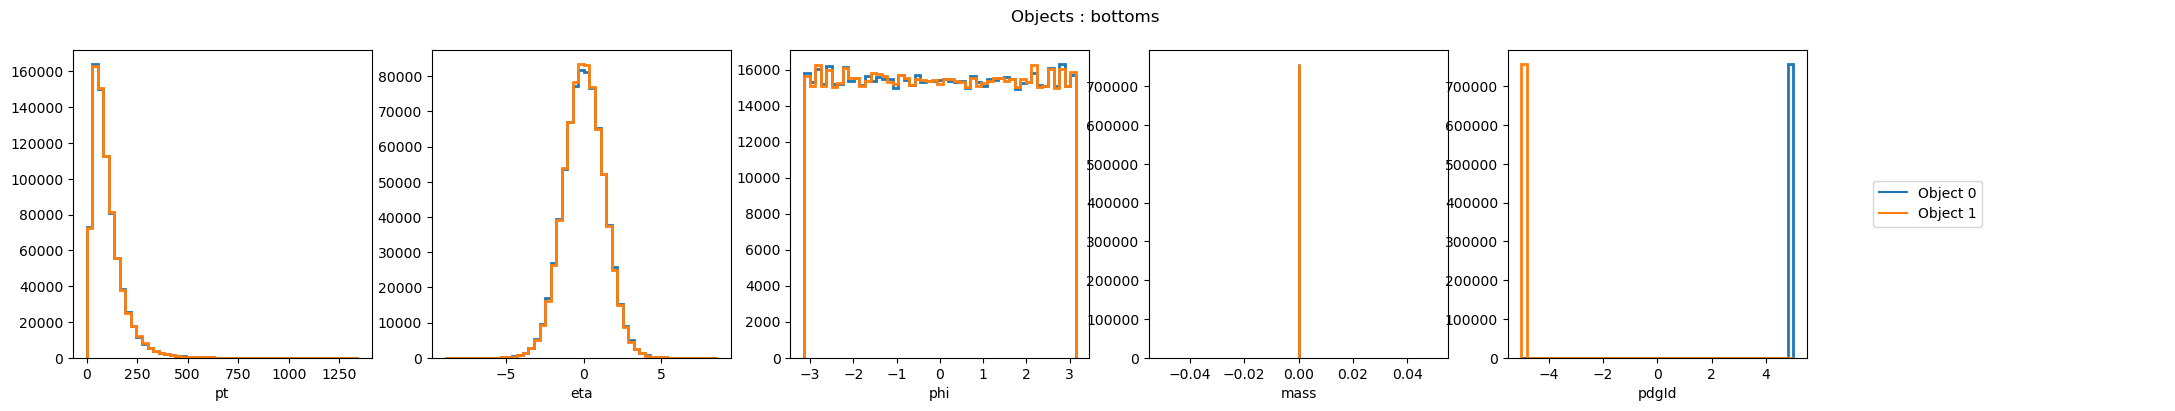

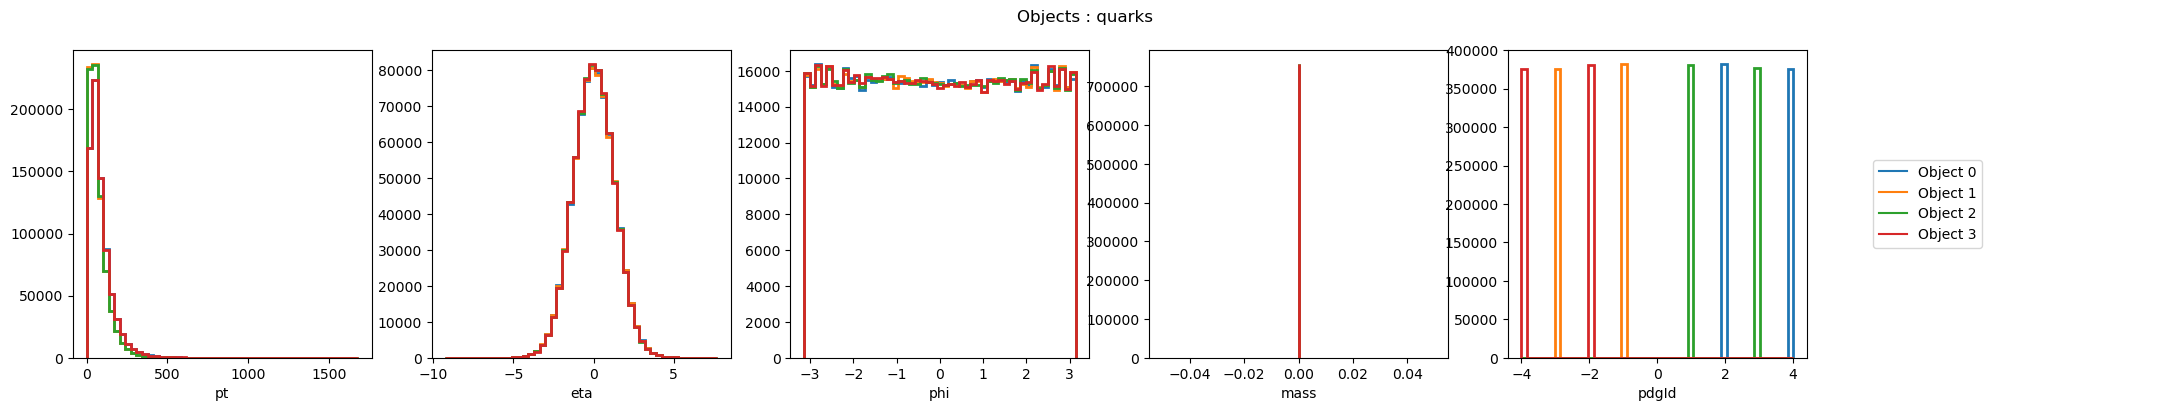

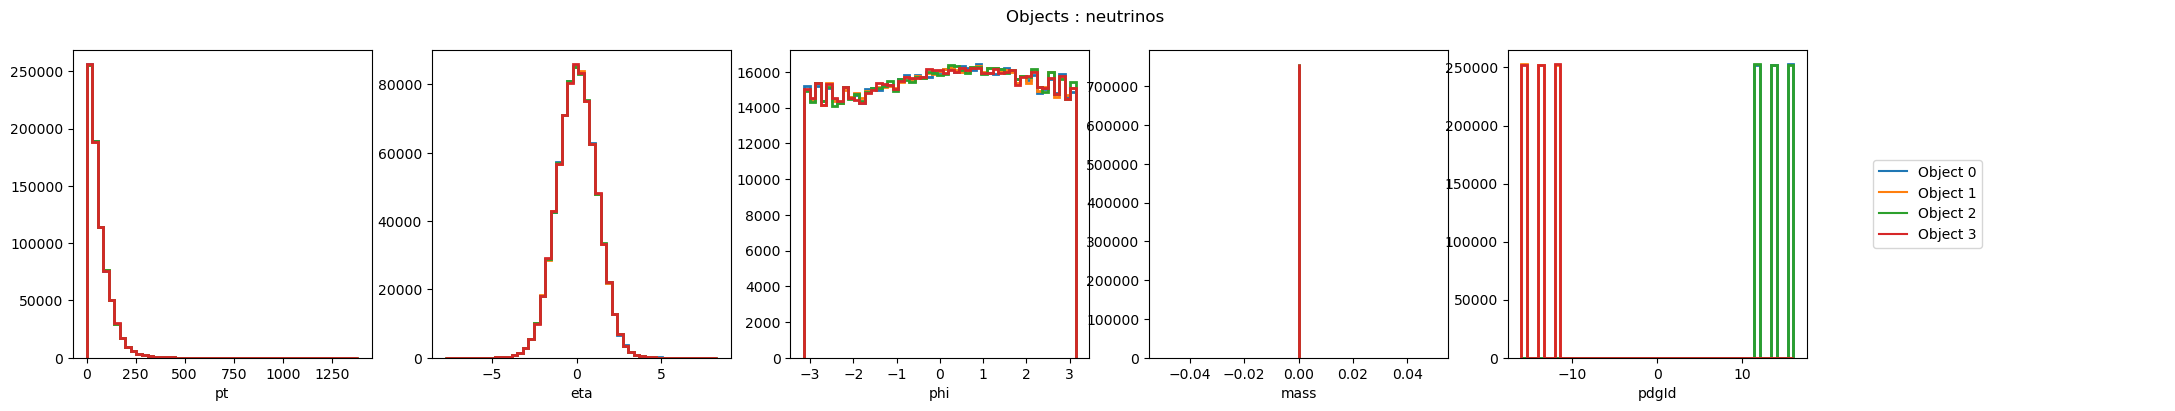

After preprocessing


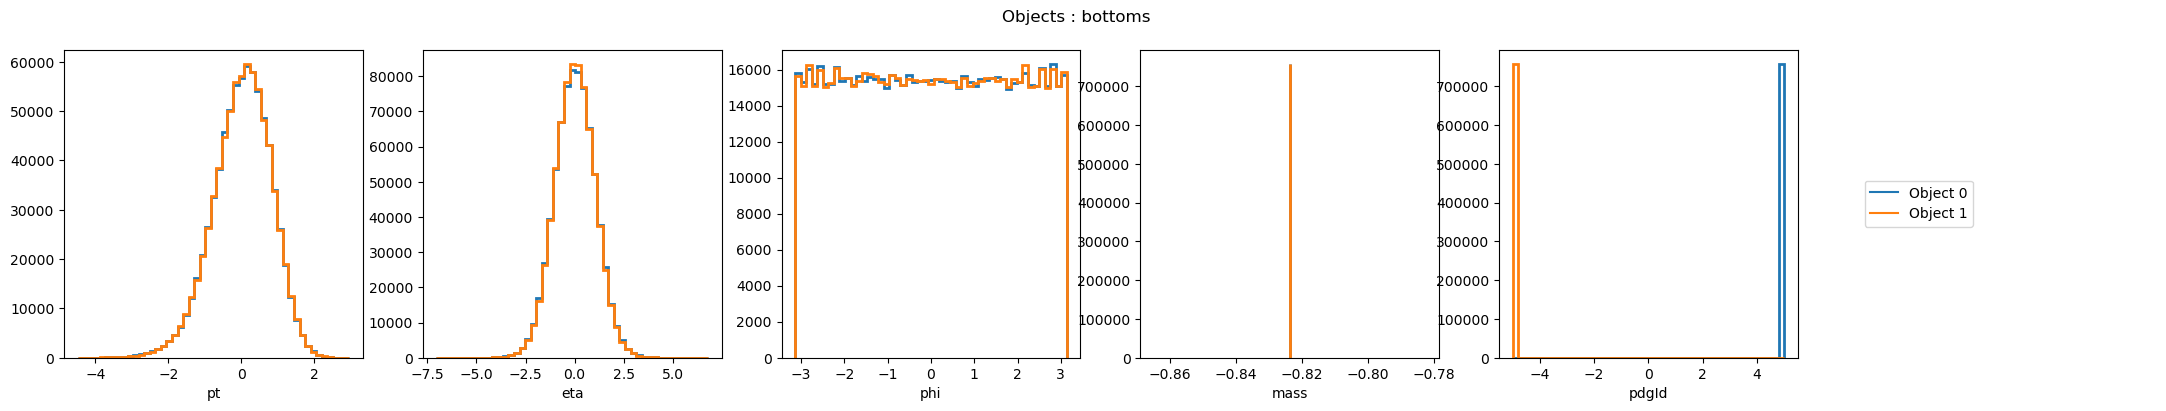

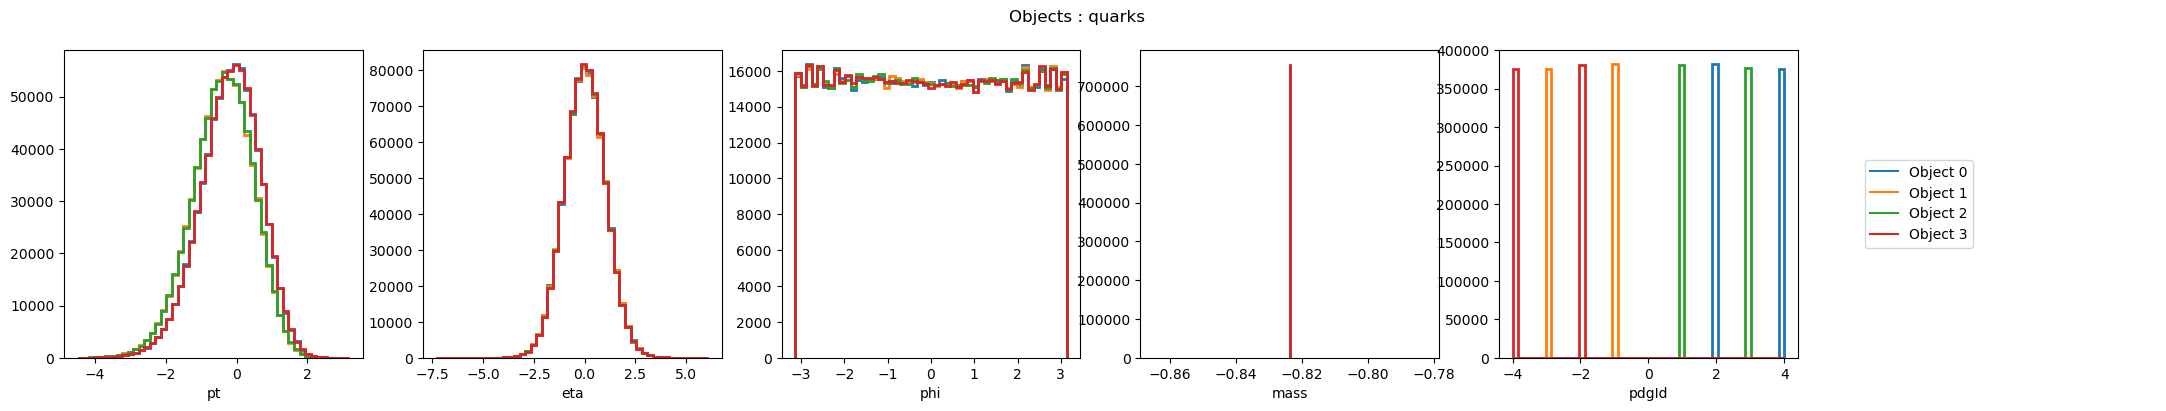

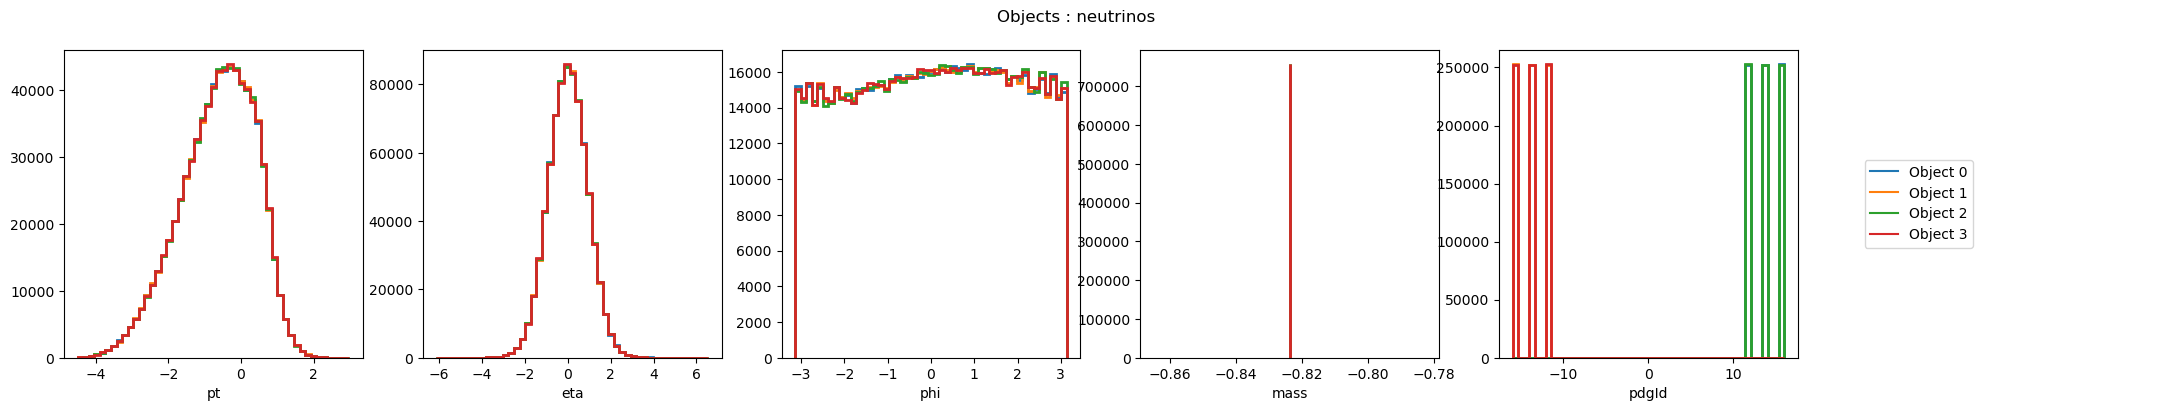

In [4]:
print ('Before preprocessing')
hard_dataset.plot(selection=True,raw=True)
print ('After preprocessing')
hard_dataset.plot(selection=True,raw=False)

# Reco dataset

In [6]:
data_reco = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet',
    ],
    lazy = True,
    #N = data_hard.N,
)

print(data_reco)

Data object
Loaded branches:
   ... file: 231528
   ... sample: 231528
   ... tree: 231528
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... InputMet_phi
   ... InputMet_pt
   ... cleanedJet_btagDeepFlavB
   ... cleanedJet_eta
   ... cleanedJet_mass
   ... cleanedJet_phi
   ... cleanedJet_pt
   ... event
   ... ncleanedBJet
   ... ncleanedJet
   ... region
   ... weight_nominal
   ... xs_weight


Have a look at athe minimum values for Jet and MET pT in the raw dataset. This can give an indication as to what the cutoff in the SR is and hence what to set the `'pt':lowercutshift()` to in the pre-processing

In [8]:
reco_dataset = ttHRecoDataset(
    data = data_reco,
    selection = [
        'jets',
        'met',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)
print(reco_dataset)

Loading objects from /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco


Saving preprocessing to /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco
Will overwrite what is in output directory /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco/preprocessing
Preprocessing saved in /cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/ttH_reco/preprocessing
Reco dataset with 114647 events
Containing the following tensors
jets  : data ([114647, 6, 5]), mask ([114647, 6])
        Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 62.85%]
        Mask attn     : [True, True, True, True, True, True]
        Weights       : 114647.00, 114647.00, 114647.00, 114647.00, 114647.00, 114647.00
        Features      : ['pt', 'eta', 'phi', 'mass', 'btag']
        Selected for batches : True
met   : data ([114647, 1, 4]), mask ([114647, 1])
        Mask exist    : [100.00%]
        Mask attn     : [True]
        Weights       : 114647.00
        Features      : ['pt', 'eta', 'phi', 'mass']
        Selected for batches : True
Preprocessing steps
S

Before preprocessing


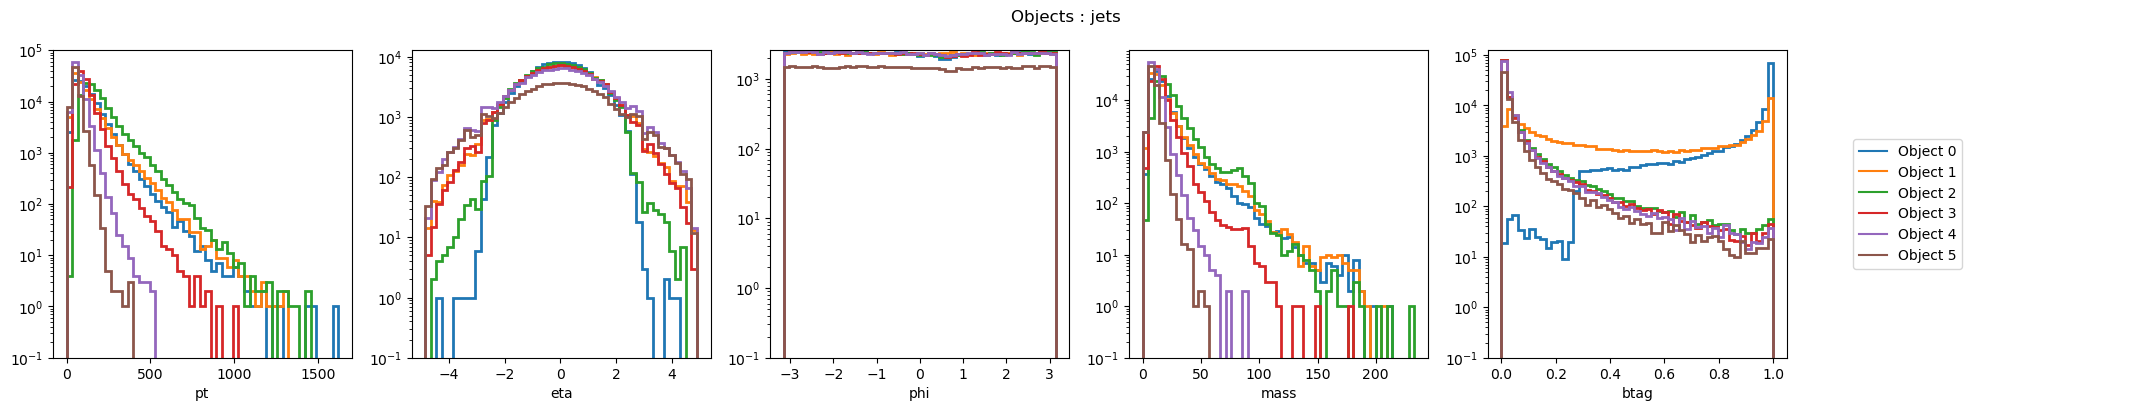

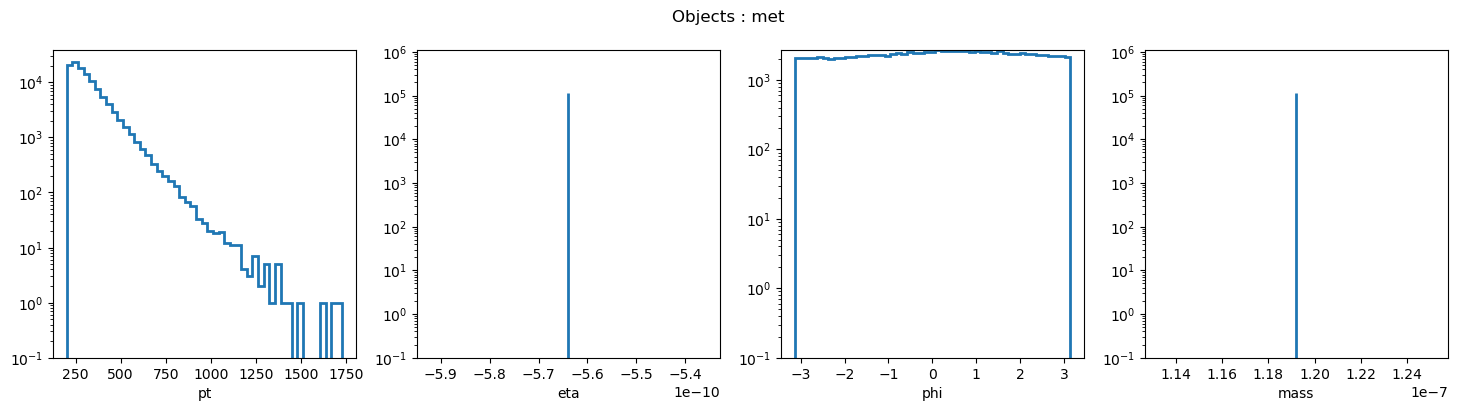

After preprocessing


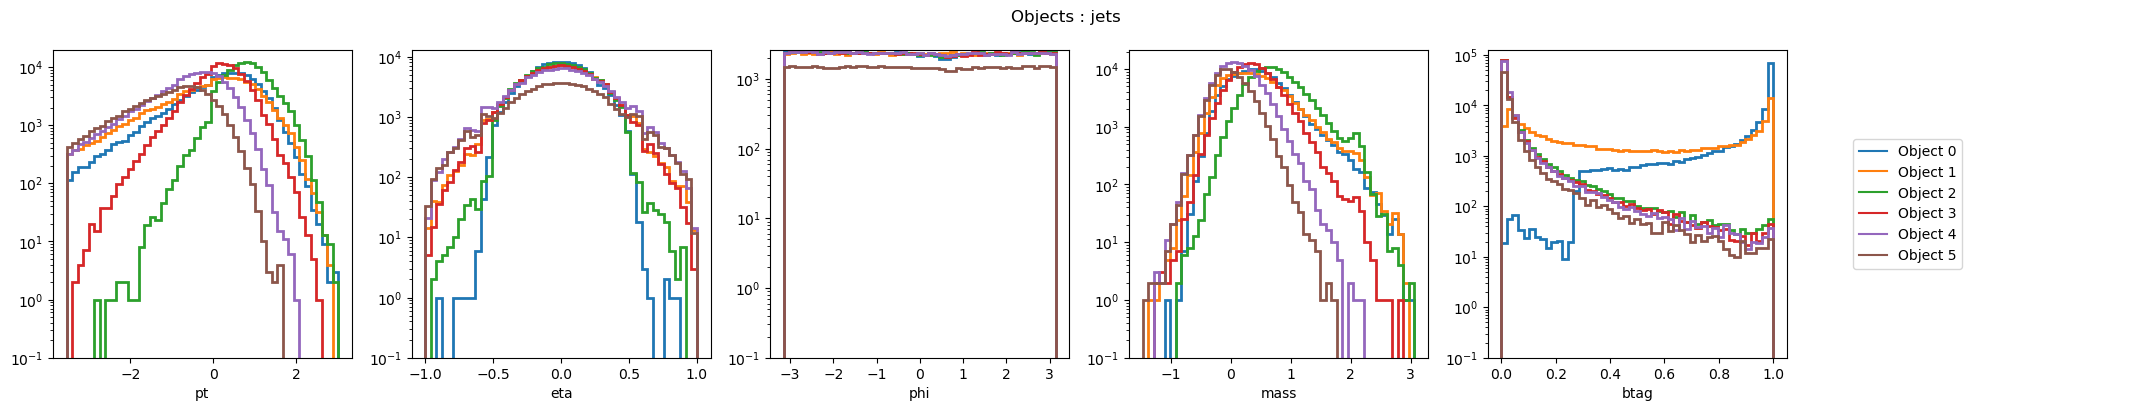

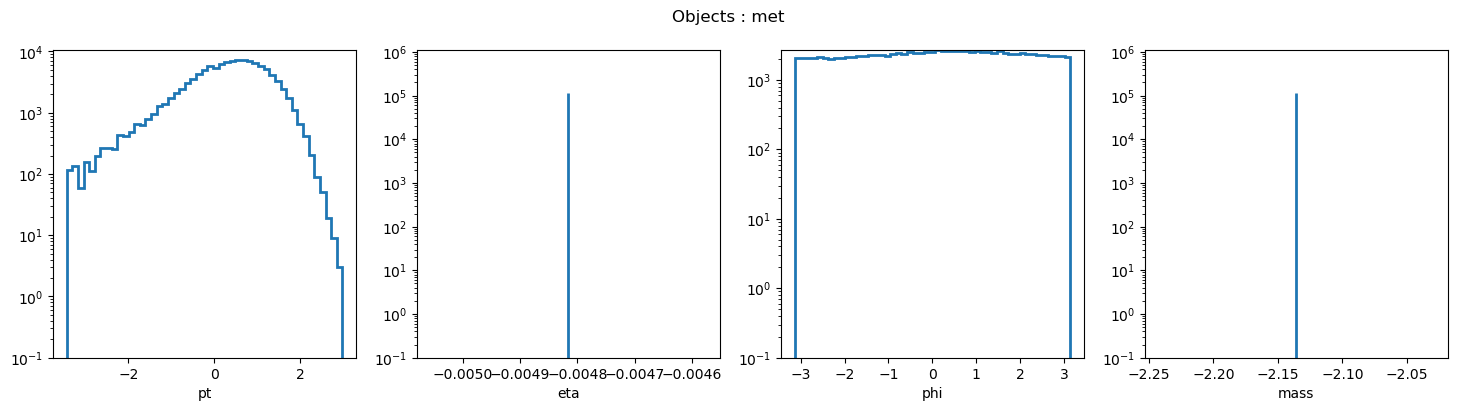

In [9]:
print ('Before preprocessing')
reco_dataset.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
reco_dataset.plot(selection=True,raw=False,log=True)

# Combined dataset

In [ ]:
combined_dataset = CombinedDataset(
    hard_dataset=hard_dataset,
    reco_dataset=reco_dataset,
)
print(combined_dataset)

Intersection Branch: event
Hard Datset keys: dict_keys(['file', 'tree', 'sample', 'intersection'])
Reco Datset keys: dict_keys(['file', 'tree', 'sample', 'intersection'])
Intersection branches : `event` for hard dataset and `event` for reco dataset
Looking into file metadata
Will pair these files together :
   - /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet <-> /cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet
For entry 0 : from 756642 events, 91819 selected
For entry 1 : from 114647 events, 91819 selected
Combined dataset (extracting 91819 events of the following) :
Parton dataset with 756642 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6]
 Final states masses   : [125.2, 172.57, 172.57]
Containing the following tensors
bottoms    : data ([756642, 2, 5]), mask ([756642, 2])
             Mask exist    : [100.00%, 100.00%]
             Mask attn     : [True

In [ ]:
inference_loader = DataLoader(
    combined_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=16,
    pin_memory=True,
)

Reco
jets torch.Size([256, 6, 5]) torch.Size([256, 6])
met torch.Size([256, 1, 4]) torch.Size([256, 1])
Hard
bottoms torch.Size([256, 2, 5]) torch.Size([256, 2])
quarks torch.Size([256, 4, 5]) torch.Size([256, 4])
neutrinos torch.Size([256, 4, 5]) torch.Size([256, 4])


In [ ]:
checkpoint_path = "model_checkpoints/model_epoch_80.ckpt"

# Load the model from the checkpoint.
# If the checkpoint saved hyperparameters, you can simply do:
model = StandardCFM.load_from_checkpoint(checkpoint_path)
model.to(accelerator)
model.eval()
print("Model loaded from checkpoint:", checkpoint_path)

# TransferCFM

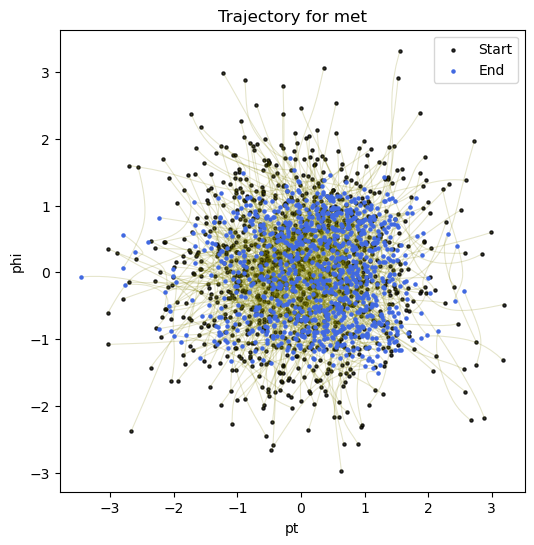

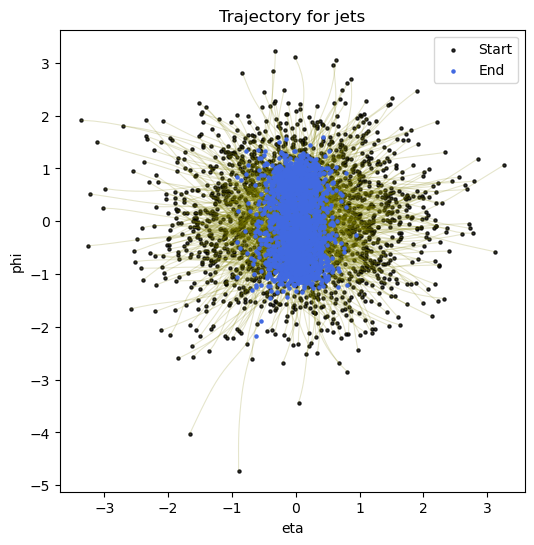

In [ ]:
batch = next(iter(inference_loader))
batch = CFMSamplingCallback.move_batch_to_device(batch, model.device)


with torch.no_grad():
    model = model.to(model.device)

    # Extract the necessary inputs for sampling
    hard_data = batch["hard"]["data"]
    hard_mask = batch["hard"]["mask"]
    reco_data = batch["reco"]["data"]
    reco_mask = batch["reco"]["mask"]

    final_samples, all_traj = model.sample(
        hard_data,
        hard_mask,
        reco_data,
        reco_mask,
        N_sample=1,
        steps=20,
        store_trajectories=True
    )

# all_traj is the shape [N_sample, steps+1, B, sum_reco, 2], used for 2D trajectory plots
# Feature indexes:
#   Jets: "pt"=0, "eta"=1 "phi"=2
#   MET: "pt"=0, "phi"=1
plot_trajectories_2d(
    all_traj,
    model,
    type_idx=1, # "Jets"=0, "met"=1
    feat_idx_x=0,
    feat_idx_y=1,
    num_events=1000,
)
plot_trajectories_2d(
    all_traj,
    model,
    type_idx=0, # "Jets"=0, "met"=1
    feat_idx_x=1,
    feat_idx_y=2,
    num_events=1000,
)

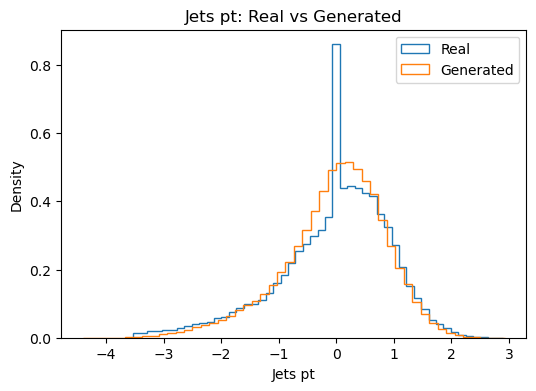

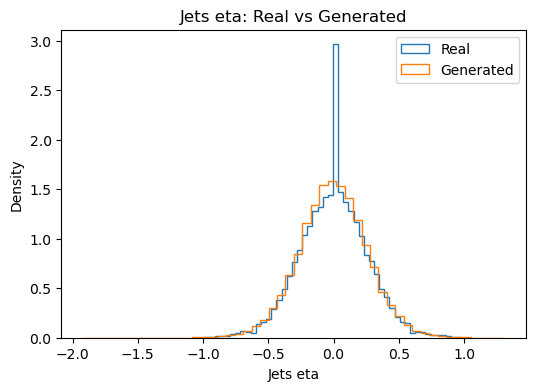

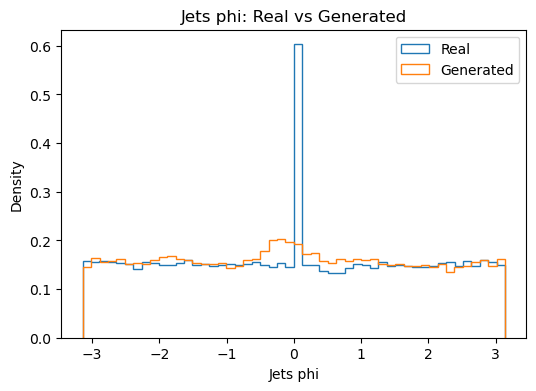

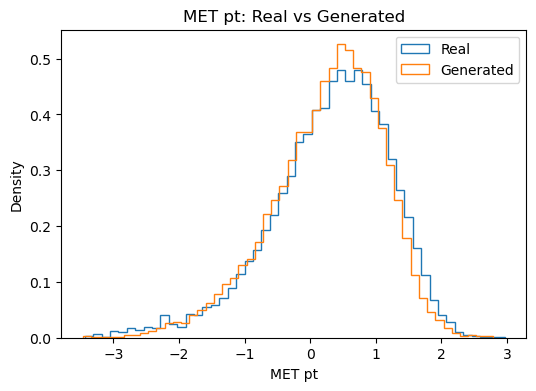

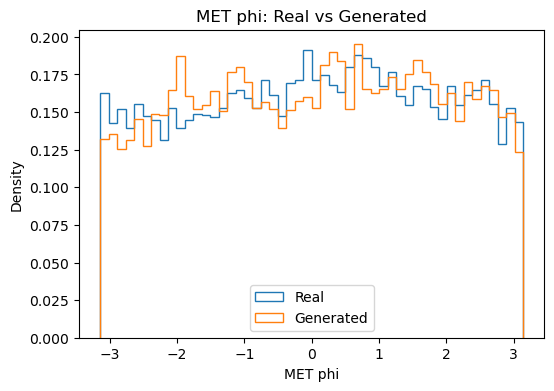

In [ ]:
# Extract real and generated data for comparison
# final_samples shape: [particle type, num samples, num events, num particles, num features] e.g.[2, 1, 10000, 6, 3]
real_data = batch["reco"]["data"] # Shape: [particle type, num events, num particles, num features] e.g.[2, 10000, 6, 5]

# Jet Feature indexes:
#   real: "pt"=0, "eta"=1 "phi"=2
#   gen: "pt"=0, "eta"=1 "phi"=2
compare_distributions(real_data[0], final_samples[0], real_feat_idx=0, gen_feat_idx=0, feat_name="Jets pt")
compare_distributions(real_data[0], final_samples[0],  real_feat_idx=1, gen_feat_idx=1, feat_name="Jets eta")
compare_distributions(real_data[0], final_samples[0],  real_feat_idx=2, gen_feat_idx=2, feat_name="Jets phi")

# MET Feature indexes:
#   real: "pt"=0, "phi"=2
#   gen: "pt"=0, "phi"=1
compare_distributions(real_data[1], final_samples[1], real_feat_idx=0, gen_feat_idx=0, feat_name="MET pt")
compare_distributions(real_data[1], final_samples[1], real_feat_idx=2, gen_feat_idx=1, feat_name="MET phi")

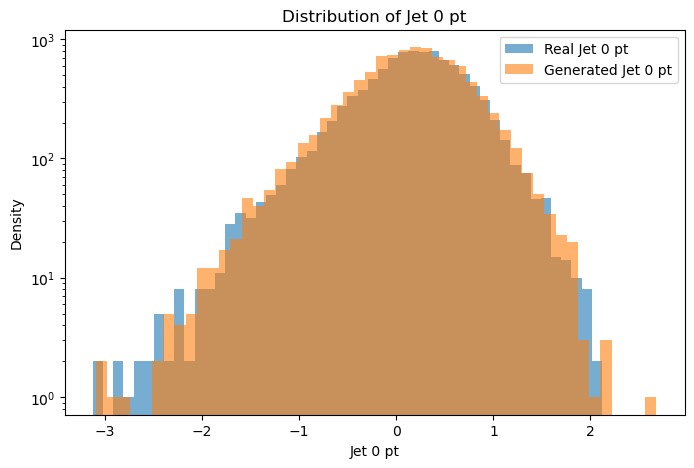

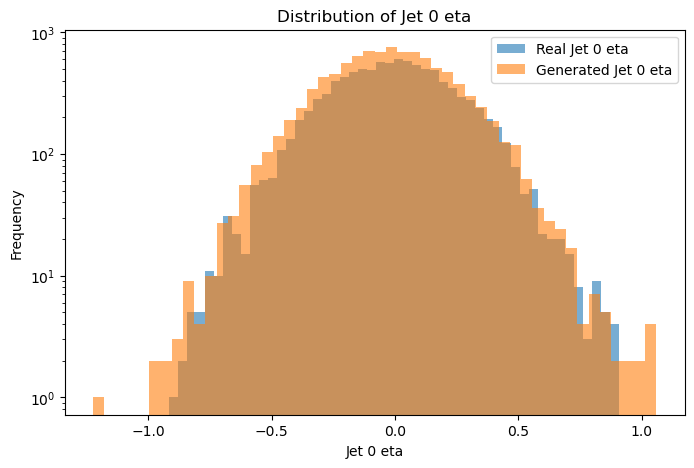

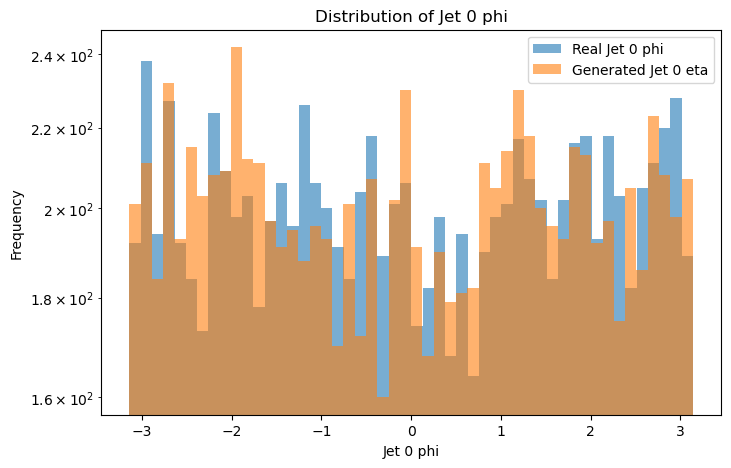

In [ ]:
real_jet_0 = real_data[0][:, 3, :]  # Shape: [num_events, num_features]
gen_jet_0 = final_samples[0][:, :, 3, :]  # Shape: [num_samples, num_events, num_features]
real_jet_0_pt = real_jet_0[:, 0]  # Shape: [num_events]
gen_jet_0_pt = gen_jet_0[:, :, 0].flatten()  # Shape: [num_samples * num_events]
real_jet_0_eta = real_jet_0[:, 1]
gen_jet_0_eta = gen_jet_0[:, :, 1].flatten()
real_jet_0_phi = real_jet_0[:, 2]
gen_jet_0_phi = gen_jet_0[:, :, 2].flatten()

plt.figure(figsize=(8, 5))
plt.hist(real_jet_0_pt, bins=50, alpha=0.6, label="Real Jet 0 pt", log=True)
plt.hist(gen_jet_0_pt, bins=50, alpha=0.6, label="Generated Jet 0 pt", log=True)
plt.xlabel("Jet 0 pt")
plt.ylabel("Density")
plt.legend()
plt.title("Distribution of Jet 0 pt")
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(real_jet_0_eta, bins=50, alpha=0.6, label="Real Jet 0 eta", log=True)
plt.hist(gen_jet_0_eta, bins=50, alpha=0.6, label="Generated Jet 0 eta", log=True)
plt.xlabel("Jet 0 eta")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Jet 0 eta")
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(real_jet_0_phi, bins=50, alpha=0.6, label="Real Jet 0 phi", log=True)
plt.hist(gen_jet_0_phi, bins=50, alpha=0.6, label="Generated Jet 0 eta", log=True)
plt.xlabel("Jet 0 phi")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Jet 0 phi")
plt.show()


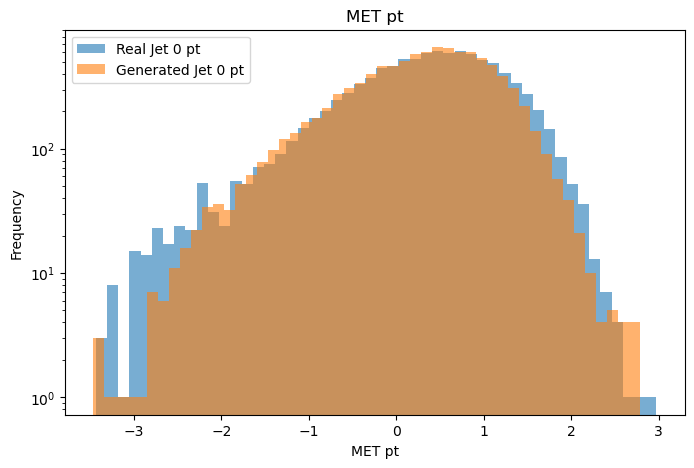

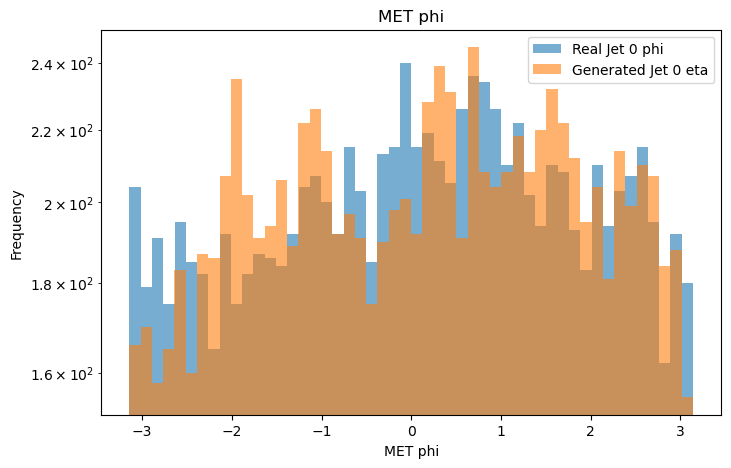

In [ ]:
real_jet_0 = real_data[1][:, 0, :]  # Shape: [num_events, num_features]
gen_jet_0 = final_samples[1][:, :, 0, :]  # Shape: [num_samples, num_events, num_features]
real_jet_0_pt = real_jet_0[:, 0]  # Shape: [num_events]
gen_jet_0_pt = gen_jet_0[:, :, 0].flatten()  # Shape: [num_samples * num_events]
real_jet_0_phi = real_jet_0[:, 2]
gen_jet_0_phi = gen_jet_0[:, :, 1].flatten()

plt.figure(figsize=(8, 5))
plt.hist(real_jet_0_pt, bins=50, alpha=0.6, label="Real Jet 0 pt", log=True)
plt.hist(gen_jet_0_pt, bins=50, alpha=0.6, label="Generated Jet 0 pt", log=True)
plt.xlabel("MET pt")
plt.ylabel("Frequency")
plt.legend()
plt.title("MET pt")
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(real_jet_0_phi, bins=50, alpha=0.6, label="Real Jet 0 phi", log=True)
plt.hist(gen_jet_0_phi, bins=50, alpha=0.6, label="Generated Jet 0 eta", log=True)
plt.xlabel("MET phi")
plt.ylabel("Frequency")
plt.legend()
plt.title("MET phi")
plt.show()


In [ ]:
# Callbacks to make plots within comet
bias = BiasCallback(
    dataset = combined_dataset_valid,               # dataset on which to evaluate bias
    preprocessing = combined_dataset.reco_dataset.preprocessing, # preprocessing pipeline to draw raw variables
    N_sample = 100,                                 # number of samples to draw
    steps = 20,                                     # Number of bridging steps
    store_trajectories = False,                     # To save trajectories plots
    frequency = 50,                                 # plotting frequency (epochs)
    raw = True,
    bins = 101,                                      # 1D/2D plot number of bins
    points = 20,                                    # Number of points for the quantile
    log_scale = True,                               # log
    batch_size = 1000,                              # Batch size to evaluate the dataset (internally makes a loaded)
    N_batch = 1,                                   # Stop after N batches (makes it faster)
    suffix = 'ttH',                                 # name for plots
    label_names = {                                 # makes nicer labels
        'pt' : 'p_T',
        'eta' : '\eta',
        'phi' : '\phi',
    },
)

sampling = SamplingCallback(
    dataset = combined_dataset_valid,           # dataset to check sampling
    preprocessing = combined_dataset.reco_dataset.preprocessing, # preprocessing pipeline
    idx_to_monitor = [5,6,7],               # idx of events in dataset to make plots with
    N_sample = 1000,                         # number of samples to draw
    steps = 20,                                     # Number of bridging steps
    store_trajectories = False,                     # To save trajectories plots
    frequency = 50,                             # plotting frequency (epochs)
    bins = 51,                                  # 1D/2D plot number of bins
    log_scale = True,                           # log
    label_names = {                             # makes nicer labels
        'pt' : 'p_T',
        'eta' : '\eta',
        'phi' : '\phi',
    },
)

In [ ]:
figures = sampling.make_sampling_plots(model,show=True)
figs = bias.make_bias_plots(model,show=True)

KeyboardInterrupt: 